In [3]:
#importing important libraries
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [4]:
#calling the file in nyse named prices.csv
df =pd.read_csv("ALLO.csv", header=0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-10,8.58,8.80,8.46,8.71,8.71,1220400
1,2022-03-11,8.81,8.82,8.14,8.17,8.17,1572500
2,2022-03-14,8.17,8.70,7.56,7.65,7.65,1472200
3,2022-03-15,7.69,8.00,7.58,7.80,7.80,1602900
4,2022-03-16,7.91,8.41,7.89,8.39,8.39,1406900


In [5]:
#size of the dataset in 851264 rows and 7 columns
print(df.shape)

(251, 7)


In [6]:
# finind the length of column named symbol
print(len(df.Date.values))

251


In [7]:
#gives the details of each columns of the dataset like mean, max etc
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,9.807849,10.155179,9.458645,9.811713,9.811713,1.878905e+06
std,2.740979,2.843398,2.661095,2.768669,2.768669,1.068684e+06
min,5.640000,5.860000,5.410000,5.620000,5.620000,6.030000e+05
25%,7.675000,7.915000,7.445000,7.670000,7.670000,1.231000e+06
50%,9.410000,9.740000,9.120000,9.480000,9.480000,1.614300e+06
75%,11.325000,11.850000,11.015000,11.415000,11.415000,2.142700e+06
max,17.230000,17.490000,16.670000,17.280001,17.280001,9.085400e+06


In [8]:
#checking whether their is any null value in the dataset
# .sum() will give the total no. of null value column vise 
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

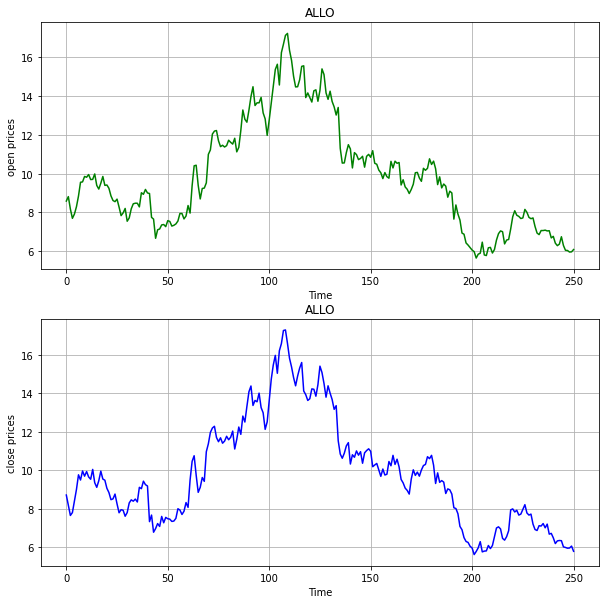

In [20]:
f, axs = plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,1,1)
open = df.Open.values.astype('float32')


plt.grid(True)
plt.xlabel('Time') 
plt.ylabel("open prices")
plt.title('ALLO')
plt.plot(open , 'g') 
    
    
plt.subplot(2,1,2)
close = df.Close.values.astype('float32')


plt.xlabel('Time') 
plt.ylabel("close prices")
plt.title('ALLO') 
plt.grid(True)
plt.plot(close , 'b')
plt.show()

In [22]:
#taking the values of closing_stock in a single list called stocks
stocks = close[:]
print(stocks)
#reshaping the stocks in 1D array form
stocks = stocks.reshape(len(stocks) , 1)

[ 8.71  8.17  7.65  7.8   8.39  9.    9.76  9.49  9.96  9.69  9.93  9.65
  9.53 10.04  9.35  9.11  9.45  9.95  9.54  9.48  9.06  8.84  8.47  8.51
  8.76  8.25  7.79  7.95  7.92  7.61  7.8   8.3   8.46  8.39  8.5   8.35
  9.11  9.04  9.43  9.25  9.18  7.33  7.67  6.78  6.97  7.23  7.08  7.6
  7.27  7.55  7.48  7.46  7.34  7.36  7.5   8.    7.93  7.7   7.87  8.32
  8.07  9.49 10.46 10.75  9.74  8.85  9.11  9.62  9.42 10.96 11.37 11.96
 12.19 12.28 11.7  11.48 11.68 11.4  11.51 11.76 11.58 11.71 12.03 11.1
 11.6  12.24 11.86 12.81 12.5  13.31 14.07 14.37 13.36 13.62 13.55 14.
 13.25 12.98 12.12 12.51 13.62 14.72 15.46 15.96 15.03 16.2  16.57 17.25
 17.28 16.58 15.81 15.36 14.81 14.38 14.89 15.3  15.59 14.11 13.92 13.62
 13.71 14.22 14.2  13.84 14.44 15.4  15.07 14.5  13.79 14.38 14.   13.67
 13.16 13.35 11.53 10.84 10.62 10.88 11.26 11.43 10.32 10.8  10.67 11.
 10.78 10.96 10.36 10.9  11.02 11.11 10.98 10.18 10.27 10.35 10.02  9.68
 10.06  9.75  9.79 10.45 10.23 10.77 10.3  10.57 10.17  9

In [23]:
# **Feature scaling the vector for better model performance.**
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling features between 0 and 1
stocks = scaler.fit_transform(stocks) # it will start learning algo and then provide scaled and dimension reduced output

In [24]:
train = int(len(stocks) * 0.80) #creating sizes of train and taking 80% percentage of the part
test = len(stocks) - train #creating sizes of test as total minus train

In [25]:
#sizes of train and test
print(train , test)

200 51


In [26]:
#divinding the values of stocks data to train from 0 to 1409 i.e 80% data
train = stocks[0:train]
print(train)

[[0.26500857]
 [0.21869642]
 [0.1740995 ]
 [0.18696398]
 [0.23756438]
 [0.28987992]
 [0.35506004]
 [0.33190393]
 [0.3722127 ]
 [0.34905654]
 [0.3696398 ]
 [0.34562606]
 [0.33533448]
 [0.37907374]
 [0.31989712]
 [0.29931384]
 [0.3284734 ]
 [0.37135506]
 [0.33619213]
 [0.33104628]
 [0.29502577]
 [0.2761578 ]
 [0.24442542]
 [0.24785596]
 [0.26929677]
 [0.22555745]
 [0.18610632]
 [0.19982845]
 [0.19725561]
 [0.17066896]
 [0.18696398]
 [0.22984564]
 [0.24356776]
 [0.23756438]
 [0.24699831]
 [0.23413384]
 [0.29931384]
 [0.29331046]
 [0.32675815]
 [0.31132078]
 [0.30531734]
 [0.1466552 ]
 [0.17581475]
 [0.09948546]
 [0.11578041]
 [0.13807893]
 [0.1252144 ]
 [0.16981131]
 [0.14150941]
 [0.16552317]
 [0.15951973]
 [0.15780449]
 [0.14751291]
 [0.14922816]
 [0.16123497]
 [0.20411664]
 [0.1981132 ]
 [0.17838764]
 [0.19296741]
 [0.23156089]
 [0.21012002]
 [0.33190393]
 [0.41509432]
 [0.43996567]
 [0.35334474]
 [0.27701545]
 [0.29931384]
 [0.34305316]
 [0.3259005 ]
 [0.45797598]
 [0.4931389 ]
 [0.54

In [27]:
#divinding the values of stocks data to test from train ending to stock data ending i.e rest 20% data
test = stocks[len(train) : ]

In [28]:
#reshaping train data in 1D array form
train = train.reshape(len(train) , 1)
#reshaping test data in 1D array form
test = test.reshape(len(test) , 1)

In [29]:
#new train and test array shape
print(train.shape , test.shape)

(200, 1) (51, 1)


In [30]:
#creating function to create trainX,testX and target(trainY, testY)
def process_data(data , n_features):
    dataX, dataY = [], [] 
    for i in range(len(data)-n_features-1):
        
        a = data[i:(i+n_features), 0]
        
        dataX.append(a) 
        
        dataY.append(data[i + n_features, 0])
        
    return np.array(dataX), np.array(dataY)

#so the stucture of trainX and trainY is somehow like this
# trainX=[[i1 , i2,...., i n_features ]] and trainY=[i + n_features]  
# trainY will show the future value of trainX values

In [31]:
n_features = 2

trainX, trainY = process_data(train, n_features)

testX, testY = process_data(test, n_features)

In [32]:
# printing the structure of train X,Y and test X,Y
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(197, 2) (197,) (48, 2) (48,)


In [33]:
# reshaping trainX and testX to use in deeplearning model
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [34]:
import math 
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation # types of layers
from keras.layers import LSTM , GRU 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error 
from keras.optimizers import Adam , SGD , RMSprop 

In [35]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

In [36]:
filepath="stock_weights1.hdf5"


lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [37]:
# creating model for training data using sequential to give series wise output between layers
model = Sequential()

model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))

model.add(Dropout(0.4))

model.add(LSTM(256))

model.add(Dropout(0.4))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 256)            199680    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 741,505
Trainable params: 741,505
Non-trai

In [38]:
# selecting the loss measurement metrics and optimizer for our model , to find out mean square error
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [39]:
# fitting the data i.e training the trainX, to relate to trainY
history = model.fit(trainX, trainY, epochs=100 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))    
#callbacks are proper

Epoch 1/100
1/2 [==============>...............] - ETA: 4s - loss: 0.2059 - mean_squared_error: 0.2059
Epoch 1: val_loss improved from -inf to 0.01029, saving model to stock_weights1.hdf5
2/2 [==============================] - 5s 1s/step - loss: 0.2204 - mean_squared_error: 0.2204 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - lr: 5.0000e-04
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2122 - mean_squared_error: 0.2122
Epoch 2: val_loss did not improve from 0.01029
2/2 [==============================] - 0s 65ms/step - loss: 0.1952 - mean_squared_error: 0.1952 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - lr: 5.0000e-04
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1604 - mean_squared_error: 0.1604
Epoch 3: val_loss did not improve from 0.01029
2/2 [==============================] - 0s 61ms/step - loss: 0.1661 - mean_squared_error: 0.1661 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - lr: 5.0000e-04
Epoch 4/100
1/2 [==

In [40]:
#predicting the value for testX
pred = model.predict(testX)

pred = scaler.inverse_transform(pred)

pred[:10]
# taking pred from 1 to 10

2/2 [==============================] - 1s 4ms/step


array([[6.963704 ],
       [6.9432044],
       [7.0009184],
       [7.0866246],
       [7.037149 ],
       [6.9672027],
       [6.9748373],
       [7.0270386],
       [7.0388284],
       [7.0445232]], dtype=float32)

In [41]:
# reshaping testY in single array
testY = testY.reshape(testY.shape[0] , 1)

testY = scaler.inverse_transform(testY)

testY[:10]

array([[5.78     ],
       [5.97     ],
       [6.2900004],
       [5.76     ],
       [5.8      ],
       [5.81     ],
       [6.09     ],
       [5.9299994],
       [6.09     ],
       [6.55     ]], dtype=float32)

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


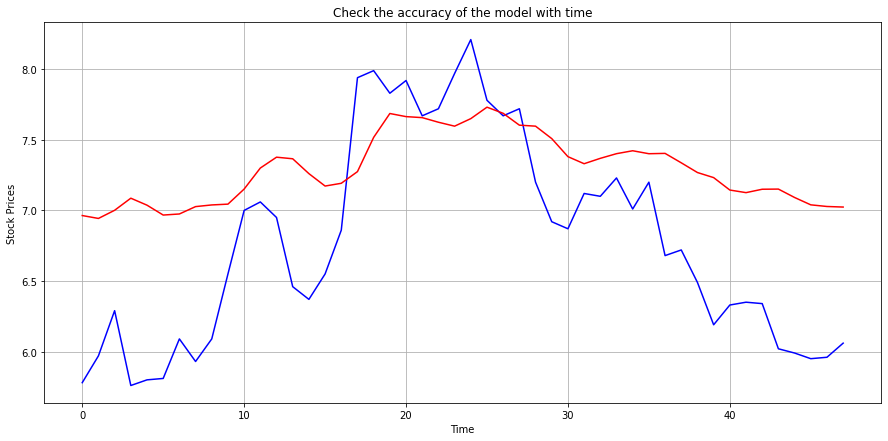

In [42]:
# ploting the graph of stock prices with time
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)

plt.plot(testY , 'b')

plt.plot(pred , 'r')

plt.xlabel('Time')

plt.ylabel('Stock Prices')

plt.title('Check the accuracy of the model with time')

plt.grid(True)

plt.show()